## Compare how much gather finds in pig v human
- Compare different databases

## Compare all vs all

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from functools import reduce
import matplotlib.pyplot as plt
from scipy.stats import kruskal

In [3]:
# open dfs
dfp = pd.read_csv('../data/250812_f_unique_weighted.gtdb_mags.pig.k31.csv', index_col=0)
dfp = dfp*100
dfp['organism'] = 'pig'
dfh = pd.read_csv('../data/250811_gather.human_gtdbMAG.k31.csv', index_col=0)
dfh = dfh*100
dfh['organism'] = 'human'
print(len(dfp), len(dfh))

3216 1944


In [4]:
# concatenate the dataframes so we have one long one
df = pd.concat([dfh, dfp])
df

,mags_and_gtdb,gtdb,mag_only,organism
basename,,,,
ERR10852874,76.518564,72.273886,38.005097,human
ERR10852876,75.255882,72.834786,27.415265,human
ERR10852883,77.633581,75.109297,34.566743,human
ERR10852889,75.153701,72.927644,35.588514,human
ERR10852927,75.588433,72.506499,32.936153,human
...,...,...,...,...
SRR8960982,88.708870,82.916143,42.567938,pig
SRR8960983,87.043238,81.550817,46.379150,pig
SRR8960984,83.605119,77.043299,44.059366,pig


In [5]:
import pandas as pd
from scipy.stats import mannwhitneyu

def remove_outliers(series):
    """Remove outliers using IQR rule"""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series >= lower) & (series <= upper)]

# Example: pairwise comparison pig vs human
org1, org2 = "pig", "human"
value_cols = ["gtdb", "mags_and_gtdb", "mag_only"]

results = {}
for col in value_cols:
    vals1 = df.loc[df["organism"] == org1, col].dropna()
    vals2 = df.loc[df["organism"] == org2, col].dropna()
    
    # Remove outliers
    vals1 = remove_outliers(vals1)
    vals2 = remove_outliers(vals2)
    
    # Mann–Whitney
    stat, p = mannwhitneyu(vals1, vals2, alternative="two-sided")
    results[col] = {"U": stat, "p": p, 
                    "n1": len(vals1), "n2": len(vals2)}

results_df = pd.DataFrame(results).T
print(results_df)


                       U              p      n1      n2
gtdb           3369121.0   4.008364e-11  3187.0  1904.0
mags_and_gtdb  4118417.0  2.858014e-115  3128.0  1904.0
mag_only       4655705.0  1.978832e-241  3216.0  1858.0


In [10]:
import pandas as pd
from scipy.stats import kruskal

# Subset for one db
subset = df_db[df_db["db"] == "gtdb"]

# Group values by organism
groups = [group["value"].values for name, group in subset.groupby("organism")]

# Kruskal–Wallis test
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H={stat:.3f}, p={p:.4f}")


Kruskal-Wallis H=46.305, p=0.0000


In [8]:
# try melted dfs, one with all, one with just the dereplication, one with just MAGs

# df_melted = pd.melt(df, id_vars=['organism'], value_vars=['no_drep', 'drep_99', 'drep_95', 'gtdb_reps', 'mags_and_gtdbreps'],
#                     var_name='drep', value_name='value')

# df_drep =  pd.melt(df, id_vars=['organism'], value_vars=['no_drep', 'drep_99', 'drep_95'],
#                     var_name='drep', value_name='value')

df_db =  pd.melt(df, id_vars=['organism'], value_vars=['gtdb', 'mags_and_gtdb', 'mag_only'],
                    var_name='db', value_name='value')

In [9]:
#subset = df[df["db"] == "gtdb"]

,organism,db,value
0,human,gtdb,72.273886
1,human,gtdb,72.834786
2,human,gtdb,75.109297
3,human,gtdb,72.927644
4,human,gtdb,72.506499
...,...,...,...
15475,pig,mag_only,42.567938
15476,pig,mag_only,46.379150
15477,pig,mag_only,44.059366
15478,pig,mag_only,42.488480


In [11]:
# set seaborn font size
sns.set(font_scale=1) 
sns.set_style("whitegrid")

In [19]:
# sns.boxplot(data=df_melted, x='drep', y='value', showfliers=False, hue='organism')
# plt.show()

/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_85461/2760147340.py:20: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


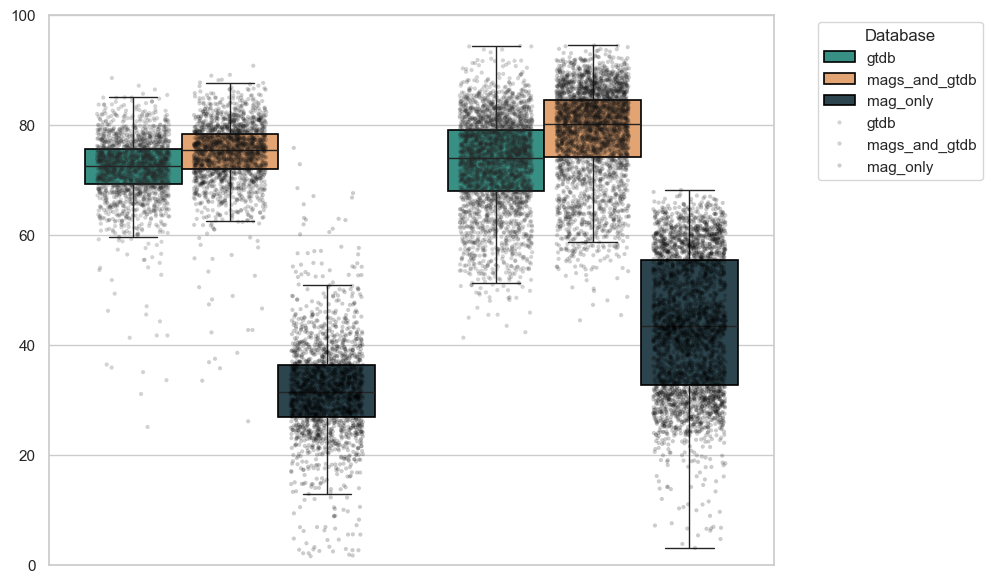

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
custom_palette = {
    "gtdb": "#2a9d8f",
    "mags_and_gtdb": "#f4a261",
    "mag_only": "#264653"
}

# Custom box style
boxprops = dict(edgecolor="black", linewidth=1.2)

plt.figure(figsize=(8, 6))
sns.boxplot(
    x="organism", y="value", hue="db",
    data=df_db, palette=custom_palette, showfliers=False,
    boxprops=boxprops
)
sns.stripplot(
    x="organism", y="value", hue="db",
    data=df_db, dodge=True, color="black",
    size=3, jitter=0.3, alpha=0.2
)

plt.xticks(rotation=45, ha='right')
plt.xticks([])
#plt.yticks([])

plt.ylabel("")
plt.xlabel("")
plt.ylim(0, 100)
plt.tight_layout()
plt.legend(title="Database", bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.savefig("../plots/250812_boxplot.funique_humanvpig.png")
plt.show()

/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_56362/710293169.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


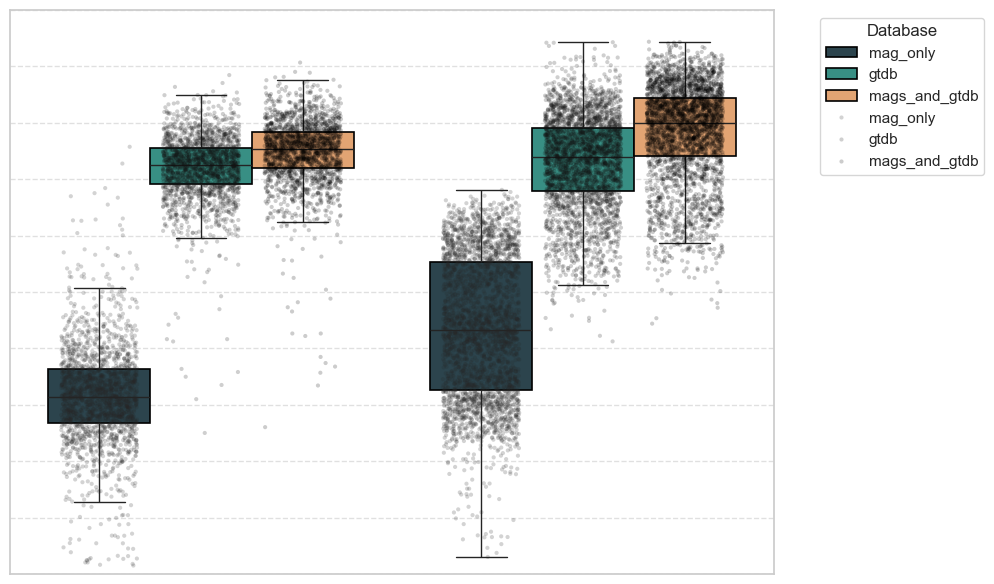

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
custom_palette = {
    "gtdb": "#2a9d8f",
    "mags_and_gtdb": "#f4a261",
    "mag_only": "#264653"
}

# Custom box style
boxprops = dict(edgecolor="black", linewidth=1.2)

plt.figure(figsize=(8, 6))
sns.boxplot(
    x="organism", y="value", hue="db",
    data=df_db, palette=custom_palette, showfliers=False,
    boxprops=boxprops,
    hue_order=["mag_only", "gtdb", "mags_and_gtdb"]
)
sns.stripplot(
    x="organism", y="value", hue="db",
    data=df_db, dodge=True, color="black",
    size=3, jitter=0.3, alpha=0.2,
    hue_order=["mag_only", "gtdb", "mags_and_gtdb"]
)

plt.xticks(rotation=45, ha='right')
plt.xticks([])
# Set ticks at 10, 20, 30 ... 100
plt.yticks(range(0, 101, 10), [""] * 11)

plt.ylabel("")
plt.xlabel("")
plt.ylim(0, 100)

# Add horizontal gridlines
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.legend(title="Database", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("../plots/250812_boxplot.funique_humanvpig.png")
plt.show()


In [13]:
# now make the curve for the pig only
dfp = dfp.reset_index()
dfp

,basename,mags_and_gtdb,gtdb,mag_only,organism
0,ERR1135178,77.636183,74.444249,41.050989,pig
1,ERR1135179,70.026550,67.377508,36.549744,pig
2,ERR1135180,66.043021,62.584017,36.069533,pig
3,ERR1135181,70.752835,67.256395,38.927363,pig
4,ERR1135182,68.988367,65.485091,36.275917,pig
...,...,...,...,...,...
3211,SRR8960982,88.708870,82.916143,42.567938,pig
3212,SRR8960983,87.043238,81.550817,46.379150,pig
3213,SRR8960984,83.605119,77.043299,44.059366,pig
3214,SRR8960985,88.735640,82.854512,42.488480,pig


In [14]:
dfp = dfp.sort_values(by="gtdb")

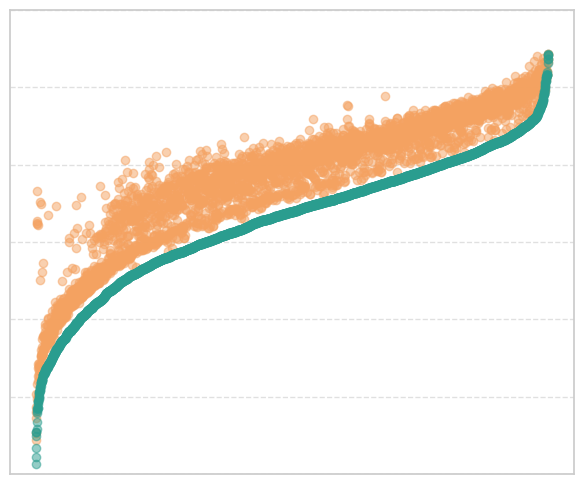

In [15]:
plt.rcParams["figure.figsize"] = (6,5)

plt.scatter(dfp['basename'], dfp['mags_and_gtdb'],color='#f4a261',alpha = 0.5)
plt.ylim(0, 100)
plt.scatter(dfp['basename'], dfp['gtdb'],color='#2a9d8f',alpha = 0.5)

plt.ylim(40, 100)
plt.yticks(range(40, 101, 10), [""] * 7)
plt.xticks([], []) 

# Horizontal gridlines at 40, 50, ...
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.xticks([], []) 
plt.tight_layout()
#plt.savefig("../plots/250812_explained.gtdb_mags.pg.png")

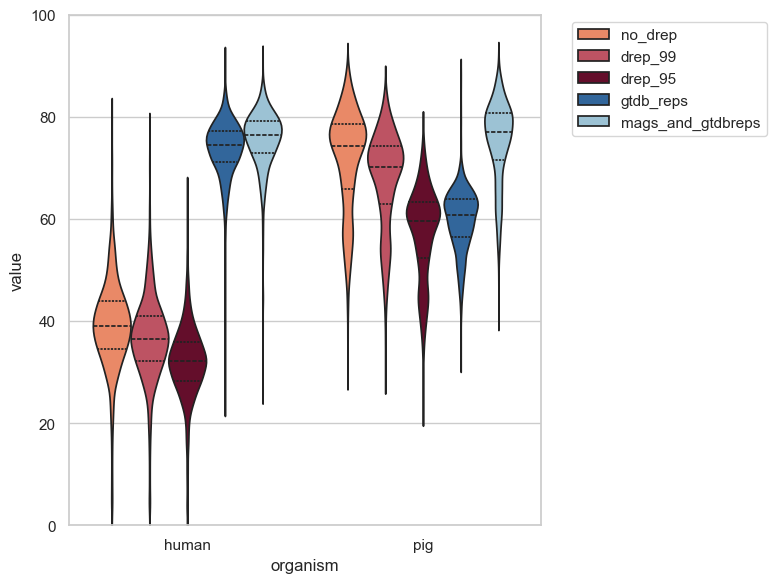

In [89]:
# create an all vs all databases plot
# i dont like this
# cc = {
#     'drep_95': '#720026',
#     'drep_99': '#ce4257',
#     'no_drep': '#ff7f51',
#     'gtdb_reps': "#2166ac",
#     'mags_and_gtdbreps': "#92c5de"
# }
# # # Define custom colors
# # cc2 = {
# #     'drep_95': 'black',
# #     'drep_99': 'black',
# #     'no_drep': 'black'
# # }
# plt.figure(figsize=(8, 6))
# sns.violinplot(x='organism', y='value', hue='drep', data=df_melted,
#                palette=cc, inner="quartiles", dodge=True)
# plt.ylim(0, 100)
# # sns.stripplot(x='organism', y='value', hue='drep', data=df_melted,
# #               palette=cc2, jitter=0.25, dodge=True, alpha=0.3, size=2)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.savefig('../plots/250716_violin_all_v_all.pdf')